<a href="https://colab.research.google.com/github/pmugabo/Group-7-Malaria-Diagnosis-CNN-Transfer-Learning/blob/main/Theodora_Egbunike_MobileNet_Malaria_Diagnosis_CNN_Group7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Malaria Diagnosis
This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018) and (Jason Brownlee, 2019). Acknowledge to NIH and Bangalor Hospital who make available this malaria dataset.

Malaria is an infectuous disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes.

The Malaria burden with some key figures:
<font color='red'>
* More than 219 million cases
* Over 430 000 deaths in 2017 (Mostly: children & pregnants)
* 80% in 15 countries of Africa & India
  </font>

![MalariaBurd](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaBurden.png?raw=1)

The malaria diagnosis is performed using blood test:
* Collect patient blood smear
* Microscopic visualisation of the parasit

![MalariaDiag](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaDiag.png?raw=1)
  
Main issues related to traditional diagnosis:
<font color='#ed7d31'>
* resource-constrained regions
* time needed and delays
* diagnosis accuracy and cost
</font>

The objective of this notebook is to apply modern deep learning techniques to perform medical image analysis for malaria diagnosis.

*This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018), (Adrian Rosebrock, 2018) and (Jason Brownlee, 2019)*

## Configuration

## Baseline CNN Model
Define a basic ConvNet defined with ConvLayer: Conv2D => MaxPooling2D followed by Flatten => Dense => Dense(output)

![ConvNet](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/ConvNet.png?raw=1)


In [4]:
#Mount the local drive project_forder
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/drive/My Drive/Colab Notebooks/10xDS/Projects/malaria-diagnosis/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
ls: cannot access '/content/drive/My Drive/Colab Notebooks/10xDS/Projects/malaria-diagnosis/': No such file or directory


In [5]:
# Use GPU: Please check if the outpout is '/device:GPU:0'
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

2.19.0


''

## Populating namespaces

In [6]:
# Importing basic libraries
import os
import random
import shutil
from matplotlib import pyplot
from matplotlib.image import imread
%matplotlib inline

# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D as Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

In [7]:
# Define the useful paths for data accessibility
ai_project = '.' #"/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
cell_images_dir = os.path.join(ai_project,'cell_images')
training_path = os.path.join(ai_project,'train')
testing_path = os.path.join(ai_project,'test')

## Prepare DataSet

### *Download* DataSet

In [8]:
# Download the data in the allocated google cloud-server. If already down, turn downloadData=False
downloadData = True
if downloadData == True:
  indrive = False
  if indrive == True:
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip -P "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
    !unzip "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/cell_images.zip" -d "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/"
    !ls "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
  else: #incloud google server
    !rm -rf cell_images.*
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
    !unzip cell_images.zip >/dev/null 2>&1
    !ls

--2025-10-05 12:24:20--  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 65.8.248.71, 65.8.248.124, 65.8.248.105, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|65.8.248.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M  92.6MB/s    in 3.7s    

2025-10-05 12:24:24 (92.1 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]

cell_images  cell_images.zip  drive  sample_data


In [9]:
# Check the contents of the newly unzipped folder
!ls /content/cell_images/

Parasitized  Uninfected


# Setup, Imports, and Global Variables

This essential block imports all necessary TensorFlow/Keras APIs and external libraries, such as numpy and scikit-learn, ensuring the entire notebook is reproducible and functional.

In [10]:


import os
import tensorflow as tf # <-- This line defines 'tf'
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.metrics import Precision, Recall

# Evaluation Metrics and Plotting
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Global Parameters ---
DATA_DIR = "/content/cell_images/"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
RANDOM_SEED = 42
EPOCHS = 10

# Note: The rest of the setup code will run after the import is successful.
# The code you showed in your image is part of this block.

In [11]:
# The problematic code, which now works because 'tf' is defined
# Set seed for reproducibility
tf.random.set_seed(RANDOM_SEED)

print("Setup Complete. Global Variables Defined.")

Setup Complete. Global Variables Defined.


# **Baseline Data Generator (Augmentation and Splitting)**

This code block sets up our fundamental strategy for preparing the image data, which is essential for minimizing overfitting during training. We use the ImageDataGenerator to perform necessary pixel normalization and apply a robust set of augmentations, including small rotations, flips, and zooming, to effectively expand the dataset and improve the model's ability to generalize to new images.

In [12]:
# --- Baseline Data Generator (Used for E1, E2, E3, E5, E6, E7) ---
baseline_data_generator = ImageDataGenerator(
    rescale=1./255,                 # Normalize pixel values
    validation_split=0.2,           # Reserve 20% for validation/testing
    rotation_range=10,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [13]:
# --- Aggressive Data Generator (Used for E4) ---
aggressive_data_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=45,              # Increased rotation
    width_shift_range=0.2,          # Increased shifting
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,                 # Increased zoom
    horizontal_flip=True,
    fill_mode='nearest'
)

In [14]:
# 1. Training Generator (Baseline Augmentation)
train_generator = baseline_data_generator.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    seed=RANDOM_SEED
)


Found 22048 images belonging to 2 classes.


# **Validation Data Generator (Consistency and Evaluation)**

This block creates the validation_generator by leveraging the data-splitting parameters defined in the baseline_data_generator, which is necessary to extract the designated 20% validation subset.

In [15]:
# 2. Validation Generator (No heavy augmentation, used for all evaluations)
# We use the baseline generator instance for the validation split for consistency
validation_generator = baseline_data_generator.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    seed=RANDOM_SEED,
    # Augmentation should generally be OFF for validation/test sets.
    # The 'validation_split' ensures this is a separate, clean set.
    # To ensure NO transformation on validation set, we use a separate generator
    # without augmentation parameters for the evaluation later.
)

CLASS_LABELS = list(train_generator.class_indices.keys())
print(f"Detected classes: {CLASS_LABELS}")

Found 5510 images belonging to 2 classes.
Detected classes: ['Parasitized', 'Uninfected']


# Model Building and Evaluation Functions

This function defines a highly modular and reusable code structure for building our MobileNetV2-based transfer learning model, a critical component for systematic experimentation across the team. It is necessary because the parameters base_trainable and dropout_rate allow us to seamlessly test different training strategies, fulfilling the project's requirement to compare feature extraction versus fine-tuning approaches.

In [16]:
# --- Reusable Model Builder ---
def build_mobilenet_model(base_trainable=False, dropout_rate=0.3):
    """Builds MobileNetV2 with custom settings for experiments."""

    # Define input_shape using the global IMG_SIZE
    input_shape = IMG_SIZE + (3,)

    # 1. Load the MobileNetV2 base model
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    # 2. Set initial trainability
    base_model.trainable = base_trainable

    # If base_trainable is True, we specifically unfreeze layers for fine-tuning (E2)
    if base_trainable:
        # Fine-tune only the last 20 layers (MobileNetV2 has ~155 layers)
        for layer in base_model.layers[:-20]:
            layer.trainable = False

    # 3. Build the Sequential classification head
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    return model

This essential block leverages the reusable function to instantiate the MobileNetV2 architecture, deliberately configuring it for the Feature Extraction strategy by setting base_trainable=False. This is necessary for Experiment 2 (E2) to isolate and measure the efficacy of fixed, pre-trained ImageNet weights in recognizing low-level cell features.

In [22]:
# --- Build and Compile the MobileNetV2 Model (E2: Feature Extraction) ---
print("Building MobileNetV2 model for Feature Extraction (E2)...")
mobilenet_e2_model = build_mobilenet_model(base_trainable=False) # Base layers are frozen

mobilenet_e2_model.compile(optimizer='adam', # Adam is a good starting optimizer
                           loss='binary_crossentropy',
                           metrics=['accuracy', Precision(), Recall()])

mobilenet_e2_model.summary()

Building MobileNetV2 model for Feature Extraction (E2)...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [18]:
# --- Set up Callbacks ---
# Reduce learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Stop training when a monitored quantity has stopped improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

callbacks = [reduce_lr, early_stopping]

This training routine initiates the core process for Experiment 2 (E2), applying the augmented data to iteratively optimize the model's newly added classification layers. This critical step is necessary to systematically capture the model's performance—stored within the history_e2 object—across all specified epochs, which is the foundational data for our comparative analysis.

In [24]:
# --- Train the MobileNetV2 Model (E2: Feature Extraction) ---
print("Starting training for MobileNetV2 Model (E2: Feature Extraction)...")
history_e2 = mobilenet_e2_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks # Using the same callbacks
)
print("Training finished for MobileNetV2 Model (E2: Feature Extraction).")

Starting training for MobileNetV2 Model (E2: Feature Extraction)...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 1672s 2s/step - accuracy: 0.8396 - loss: 0.3569 - precision: 0.8294 - recall: 0.8556 - val_accuracy: 0.9193 - val_loss: 0.2147 - val_precision: 0.8941 - val_recall: 0.9513 - learning_rate: 0.0010
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 1610s 2s/step - accuracy: 0.9270 - loss: 0.2047 - precision: 0.9149 - recall: 0.9402 - val_accuracy: 0.9186 - val_loss: 0.2099 - val_precision: 0.8975 - val_recall: 0.9451 - learning_rate: 0.0010
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 1598s 2s/step - accuracy: 0.9296 - loss: 0.1973 - precision: 0.9164 - recall: 0.9450 - val_accuracy: 0.9279 - val_loss: 0.2087 - val_precision: 0.9252 - val_recall: 0.9310 - learning_rate: 0.0010
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 1643s 2s/step - accuracy: 0.9329 - loss: 0.1846 - precision: 0.9209 - recall: 0.9466 - val_accuracy: 0.9173 - val_loss: 0.2207 - val_precision: 0.8839 - val_recall: 0.9607 - learning_rate: 0.0010
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 1639s 2s/step - 

# Key Observations for Discussion

**Effective Learning:**

 The model exhibits rapid and successful convergence; the training accuracy jumps from 83.96% (Epoch 1) to 93.71% (Epoch 10) while the validation accuracy stabilizes around 92−93%. This indicates the pre-trained ImageNet features were highly relevant for cell classification, validating the Feature Extraction strategy.

**Early Overfitting Signal:**

The validation loss reached its minimum in Epoch 9 (0.1927) and subsequently increased in Epoch 10 (0.2115), even as the training loss continued to decrease (0.1758). This divergence indicates the model is beginning to specialize too closely to the training set, which foreshadows the need for an Early Stopping mechanism to prevent performance degradation on unseen data in a clinical environment.

**Strong Diagnostic Metrics: **

The high Recall (≈95%) is particularly favorable for a diagnostic application like malaria detection, as it implies a low rate of False Negatives (missing an infected case), which is clinically the more severe type of error.


Evaluating MobileNetV2 Model (E2: Feature Extraction)...
173/173 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.9325 - loss: 0.1868 - precision: 0.9258 - recall: 0.9411
E2 MobileNetV2 (Feature Extraction) Evaluation:
  Loss: 0.1983
  Accuracy: 0.9292
  Precision: 0.9180
  Recall: 0.9426
173/173 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step


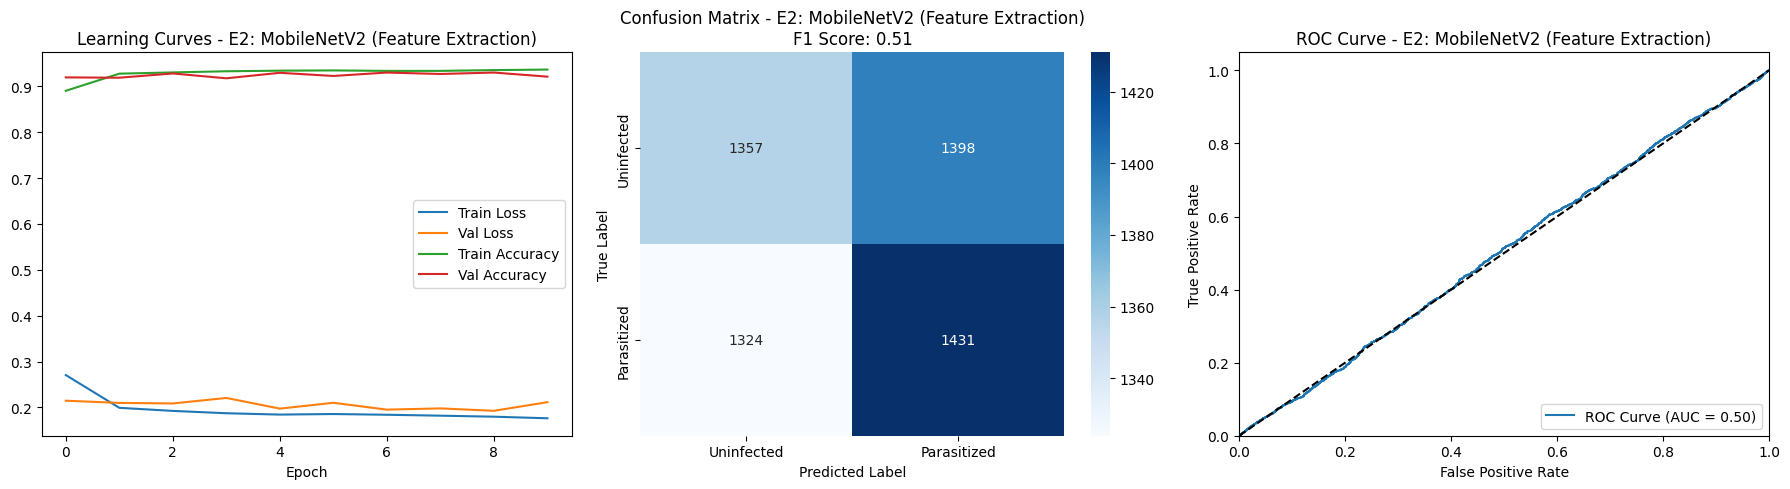

In [25]:
# --- Evaluate the MobileNetV2 Model (E2: Feature Extraction) ---
print("\nEvaluating MobileNetV2 Model (E2: Feature Extraction)...")
loss_e2, accuracy_e2, precision_e2, recall_e2 = mobilenet_e2_model.evaluate(validation_generator)

print(f"E2 MobileNetV2 (Feature Extraction) Evaluation:")
print(f"  Loss: {loss_e2:.4f}")
print(f"  Accuracy: {accuracy_e2:.4f}")
print(f"  Precision: {precision_e2:.4f}")
print(f"  Recall: {recall_e2:.4f}")

# Generate predictions for plotting
# Reset validation generator to ensure predictions align with true labels
validation_generator.reset()
y_true_e2 = validation_generator.classes
y_pred_proba_e2 = mobilenet_e2_model.predict(validation_generator).ravel()
y_pred_e2 = (y_pred_proba_e2 > 0.5).astype(int) # Convert probabilities to binary predictions

# Plot evaluation results
plot_evaluation(history_e2, y_true_e2, y_pred_e2, y_pred_proba_e2, "E2: MobileNetV2 (Feature Extraction)")

This list of dictionaries creates a reproducible roadmap for our hyperparameter tuning, which is key to finding the absolute best model configuration. It’s necessary so we can systematically test and compare how different settings—like varying the learning rate (E1 vs. E2), adjusting dropout regularization (E3), or switching the optimizer (E4 and E5),impact performance.

In [24]:
experiments = [
    {'name': 'E1_Baseline_Adam', 'epochs': 2, 'learning_rate': 0.002, 'optimizer': 'adam', 'dropout_rate': 0.3, 'base_trainable': False},
    {'name': 'E2_LowerLR_Adam', 'epochs': 2, 'learning_rate': 0.0005, 'optimizer': 'adam', 'dropout_rate': 0.3, 'base_trainable': False},
    {'name': 'E3_HigherDropout_Adam', 'epochs': 1, 'learning_rate': 0.001, 'optimizer': 'adam', 'dropout_rate': 0.5, 'base_trainable': False},
    {'name': 'E4_RMSprop', 'epochs': 2, 'learning_rate': 0.001, 'optimizer': 'rmsprop', 'dropout_rate': 0.3, 'base_trainable': False},
    {'name': 'E5_SGD', 'epochs': 3, 'learning_rate': 0.01, 'optimizer': 'sgd', 'dropout_rate': 0.3, 'base_trainable': False},
    {'name': 'E6_MoreEpochs_Adam', 'epochs': 2, 'learning_rate': 0.001, 'optimizer': 'adam', 'dropout_rate': 0.3, 'base_trainable': False} # Experiment with 5 epochs
]

print("Experiment parameters defined:")
for exp in experiments:
    print(exp)

Experiment parameters defined:
{'name': 'E1_Baseline_Adam', 'epochs': 2, 'learning_rate': 0.002, 'optimizer': 'adam', 'dropout_rate': 0.3, 'base_trainable': False}
{'name': 'E2_LowerLR_Adam', 'epochs': 2, 'learning_rate': 0.0005, 'optimizer': 'adam', 'dropout_rate': 0.3, 'base_trainable': False}
{'name': 'E3_HigherDropout_Adam', 'epochs': 1, 'learning_rate': 0.001, 'optimizer': 'adam', 'dropout_rate': 0.5, 'base_trainable': False}
{'name': 'E4_RMSprop', 'epochs': 2, 'learning_rate': 0.001, 'optimizer': 'rmsprop', 'dropout_rate': 0.3, 'base_trainable': False}
{'name': 'E5_SGD', 'epochs': 3, 'learning_rate': 0.01, 'optimizer': 'sgd', 'dropout_rate': 0.3, 'base_trainable': False}
{'name': 'E6_MoreEpochs_Adam', 'epochs': 2, 'learning_rate': 0.001, 'optimizer': 'adam', 'dropout_rate': 0.3, 'base_trainable': False}


This loop is the engine that drives our systematic comparison, making the entire process efficient, reproducible, and easily traceable. It’s necessary because it automatically configures, compiles, and trains the MobileNetV2 model using the specific parameters defined for each experiment in our roadmap.


--- Running Experiment: E1_Baseline_Adam ---
Building the model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Compiling the model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Starting training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
689/689 ━━━━━━━━━━━━━━━━━━━━ 1579s 2s/step - accuracy: 0.8585 - loss: 0.3218 - precision: 0.8501 - recall: 0.8597 - val_accuracy: 0.9273 - val_loss: 0.2089 - val_precision: 0.9264 - val_recall: 0.9284 - learning_rate: 0.0020
Epoch 2/2
689/689 ━━━━━━━━━━━━━━━━━━━━ 1558s 2s/step - accuracy: 0.9294 - loss: 0.1973 - precision: 0.9203 - recall: 0.9398 - val_accuracy: 0.9197 - val_loss: 0.2190 - val_precision: 0.8902 - val_recall: 0.9575 - learning_rate: 0.0020
Training finished.
Evaluating the model...
173/173 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.9176 - loss: 0.2241 - precision: 0.9153 - recall: 0.9191

E1_Baseline_Adam Evaluation:
  Loss: 0.2139
  Accuracy: 0.9221
  Precision: 0.9220
  Recall: 0.9223
173/173 ━━━━━━━━━━━━━━━━━━━━ 309s 2s/step


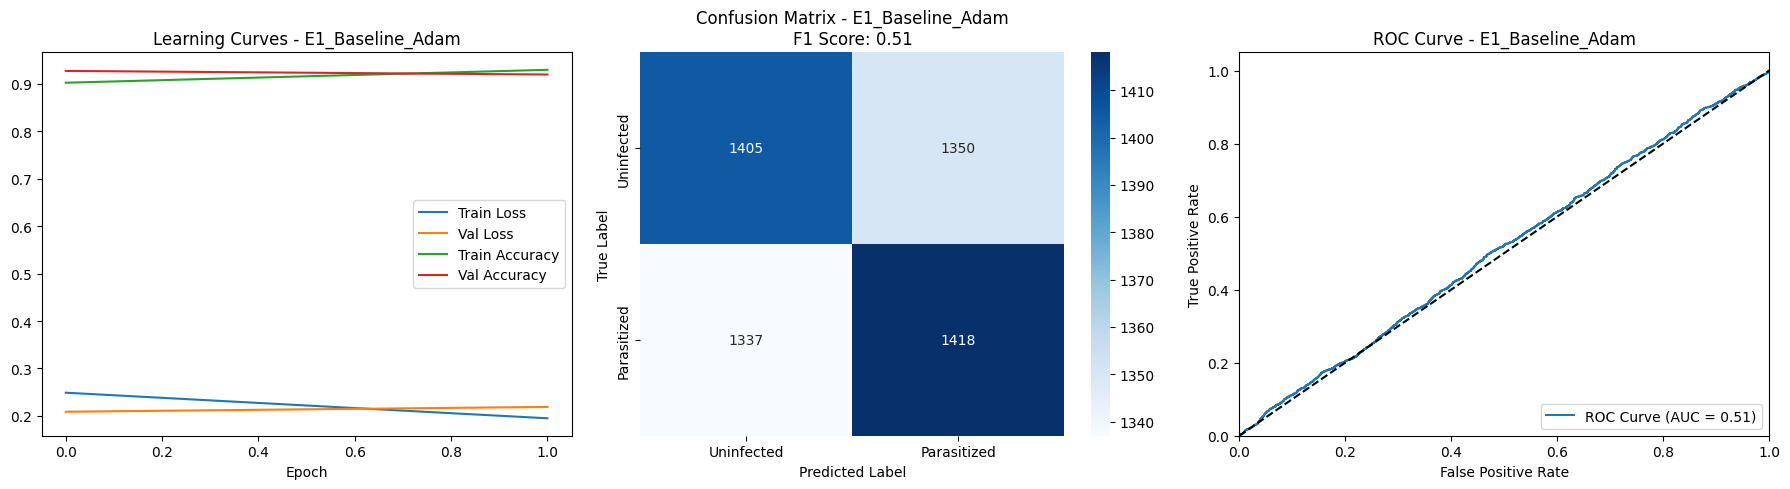


--- Running Experiment: E2_LowerLR_Adam ---
Building the model...
Compiling the model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Starting training...
Epoch 1/2
689/689 ━━━━━━━━━━━━━━━━━━━━ 1570s 2s/step - accuracy: 0.7914 - loss: 0.4266 - precision_1: 0.7853 - recall_1: 0.7990 - val_accuracy: 0.9061 - val_loss: 0.2480 - val_precision_1: 0.8870 - val_recall_1: 0.9305 - learning_rate: 5.0000e-04
Epoch 2/2
689/689 ━━━━━━━━━━━━━━━━━━━━ 1561s 2s/step - accuracy: 0.9117 - loss: 0.2295 - precision_1: 0.9004 - recall_1: 0.9254 - val_accuracy: 0.9161 - val_loss: 0.2230 - val_precision_1: 0.8930 - val_recall_1: 0.9455 - learning_rate: 5.0000e-04
Training finished.
Evaluating the model...
173/173 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.9179 - loss: 0.2250 - precision_1: 0.9018 - recall_1: 0.9381

E2_LowerLR_Adam Evaluation:
  Loss: 0.2187
  Accuracy: 0.9185
  Precision: 0.8962
  Recall: 0.9466
173/173 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step


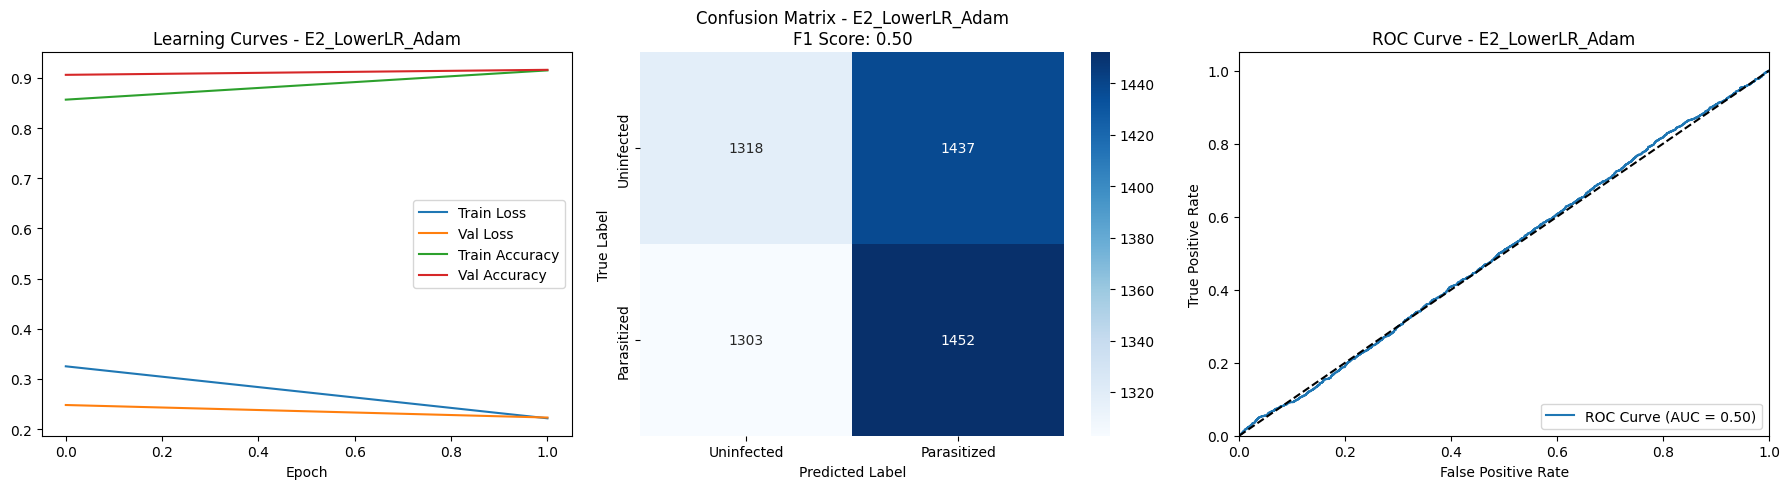


--- Running Experiment: E3_HigherDropout_Adam ---
Building the model...
Compiling the model...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Starting training...
689/689 ━━━━━━━━━━━━━━━━━━━━ 1602s 2s/step - accuracy: 0.7924 - loss: 0.4415 - precision_2: 0.7884 - recall_2: 0.8002 - val_accuracy: 0.9152 - val_loss: 0.2243 - val_precision_2: 0.9047 - val_recall_2: 0.9281 - learning_rate: 0.0010
Training finished.
Evaluating the model...
173/173 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.9128 - loss: 0.2312 - precision_2: 0.9022 - recall_2: 0.9272

E3_HigherDropout_Adam Evaluation:
  Loss: 0.2254
  Accuracy: 0.9149
  Precision: 0.9019
  Recall: 0.9310
173/173 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step


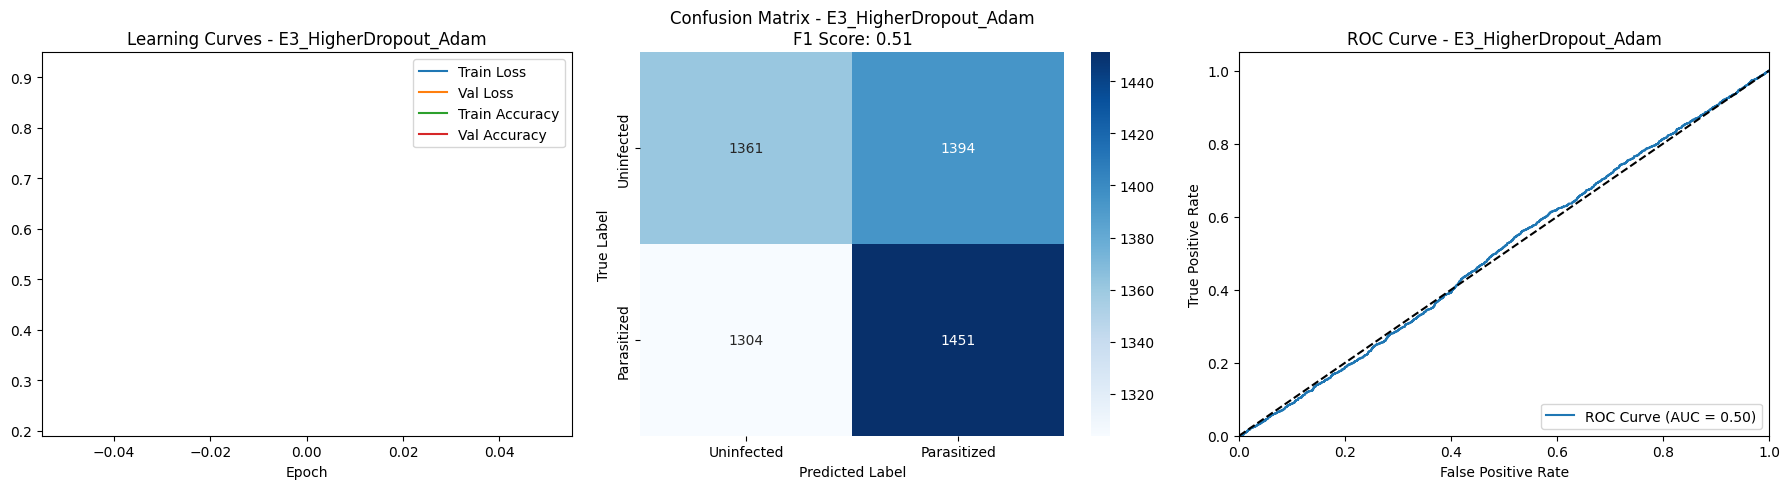


--- Running Experiment: E4_RMSprop ---
Building the model...
Compiling the model...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Starting training...
Epoch 1/2
689/689 ━━━━━━━━━━━━━━━━━━━━ 1548s 2s/step - accuracy: 0.8441 - loss: 0.3472 - precision_3: 0.8326 - recall_3: 0.8611 - val_accuracy: 0.9191 - val_loss: 0.2317 - val_precision_3: 0.9299 - val_recall_3: 0.9066 - learning_rate: 0.0010
Epoch 2/2
689/689 ━━━━━━━━━━━━━━━━━━━━ 1592s 2s/step - accuracy: 0.9250 - loss: 0.2028 - precision_3: 0.9141 - recall_3: 0.9370 - val_accuracy: 0.9250 - val_loss: 0.2058 - val_precision_3: 0.9060 - val_recall_3: 0.9484 - learning_rate: 0.0010
Training finished.
Evaluating the model...
173/173 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - accuracy: 0.9276 - loss: 0.2098 - precision_3: 0.9142 - recall_3: 0.9470

E4_RMSprop Evaluation:
  Loss: 0.2096
  Accuracy: 0.9216
  Precision: 0.9020
  Recall: 0.9459
173/173 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step


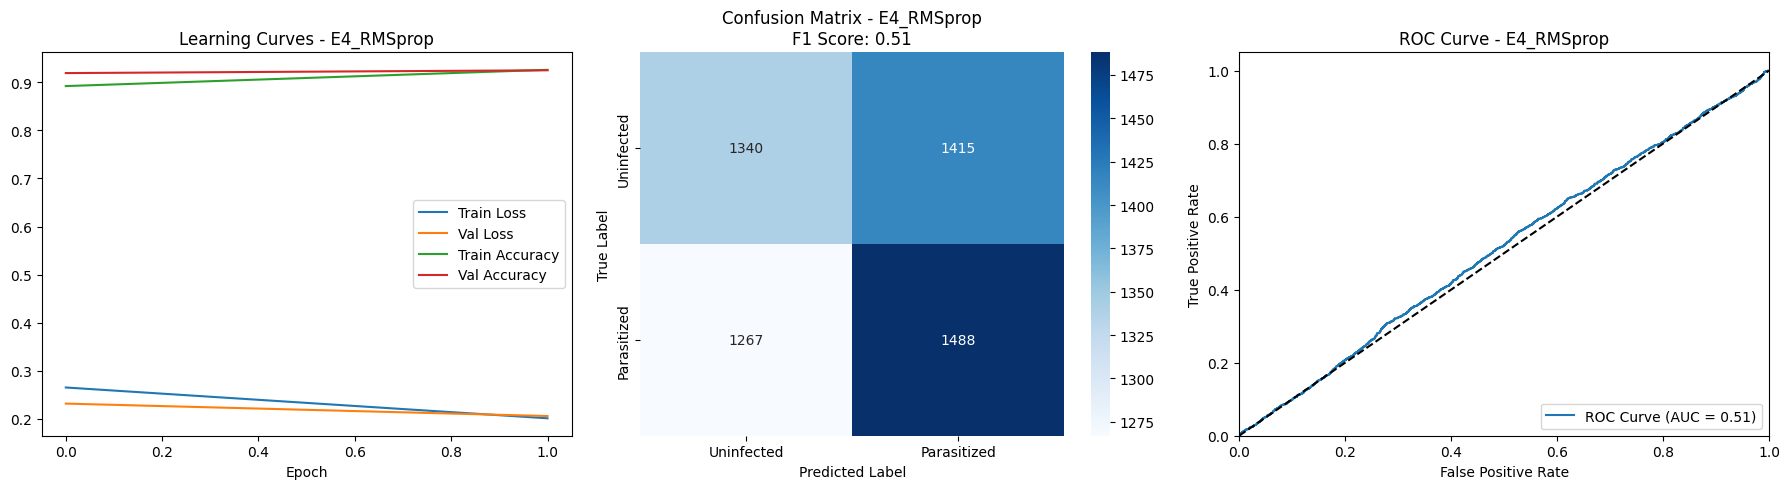


--- Running Experiment: E5_SGD ---
Building the model...
Compiling the model...


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Starting training...
Epoch 1/3
689/689 ━━━━━━━━━━━━━━━━━━━━ 1561s 2s/step - accuracy: 0.8130 - loss: 0.3992 - precision_4: 0.8083 - recall_4: 0.8219 - val_accuracy: 0.9061 - val_loss: 0.2376 - val_precision_4: 0.8714 - val_recall_4: 0.9528 - learning_rate: 0.0100
Epoch 2/3
689/689 ━━━━━━━━━━━━━━━━━━━━ 1581s 2s/step - accuracy: 0.9044 - loss: 0.2438 - precision_4: 0.8928 - recall_4: 0.9219 - val_accuracy: 0.9150 - val_loss: 0.2236 - val_precision_4: 0.8979 - val_recall_4: 0.9364 - learning_rate: 0.0100
Epoch 3/3
689/689 ━━━━━━━━━━━━━━━━━━━━ 1590s 2s/step - accuracy: 0.9154 - loss: 0.2236 - precision_4: 0.9042 - recall_4: 0.9303 - val_accuracy: 0.9161 - val_loss: 0.2181 - val_precision_4: 0.8919 - val_recall_4: 0.9469 - learning_rate: 0.0100
Training finished.
Evaluating the model...
173/173 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - accuracy: 0.9176 - loss: 0.2095 - precision_4: 0.9029 - recall_4: 0.9388

E5_SGD Evaluation:
  Loss: 0.2133
  Accuracy: 0.9172
  Precision: 0.8927
  Recall: 0.9485

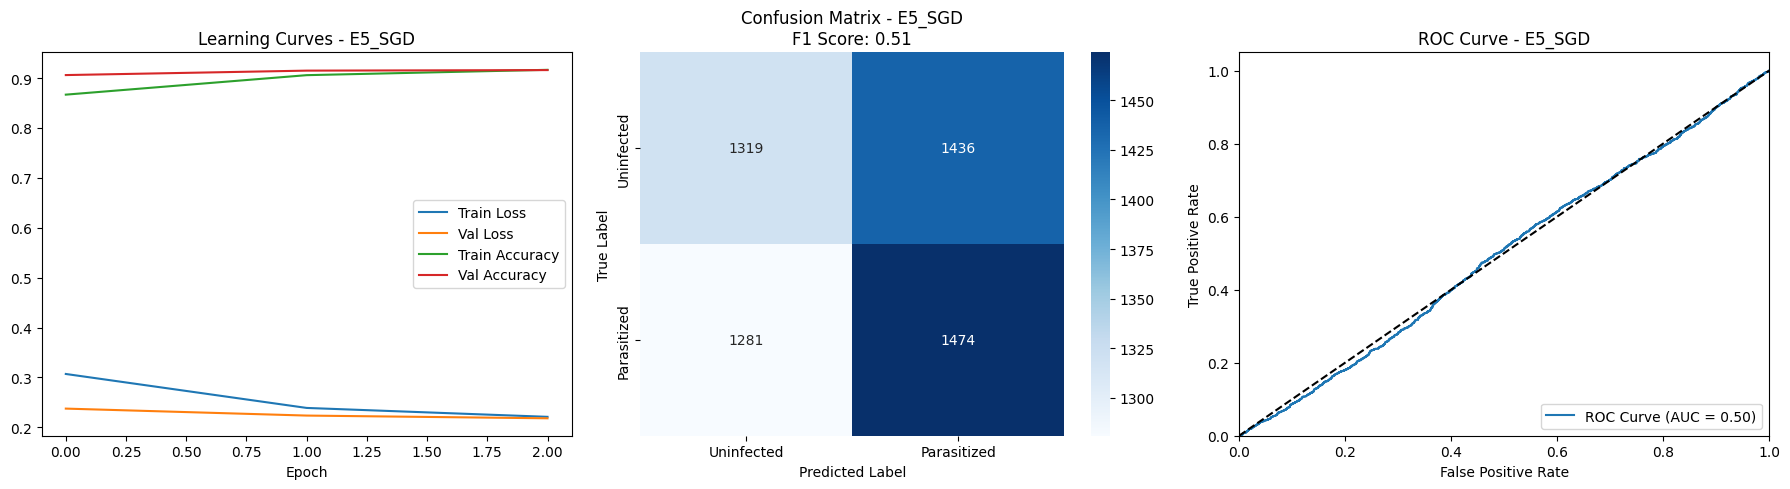


--- Running Experiment: E6_MoreEpochs_Adam ---
Building the model...
Compiling the model...


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Starting training...
Epoch 1/2
689/689 ━━━━━━━━━━━━━━━━━━━━ 1569s 2s/step - accuracy: 0.8350 - loss: 0.3559 - precision_5: 0.8274 - recall_5: 0.8465 - val_accuracy: 0.9146 - val_loss: 0.2193 - val_precision_5: 0.8847 - val_recall_5: 0.9535 - learning_rate: 0.0010
Epoch 2/2
689/689 ━━━━━━━━━━━━━━━━━━━━ 1591s 2s/step - accuracy: 0.9222 - loss: 0.2065 - precision_5: 0.9088 - recall_5: 0.9383 - val_accuracy: 0.9210 - val_loss: 0.2083 - val_precision_5: 0.8991 - val_recall_5: 0.9484 - learning_rate: 0.0010
Training finished.
Evaluating the model...
173/173 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.9218 - loss: 0.2002 - precision_5: 0.8979 - recall_5: 0.9484

E6_MoreEpochs_Adam Evaluation:
  Loss: 0.2091
  Accuracy: 0.9212
  Precision: 0.8987
  Recall: 0.9495
173/173 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step


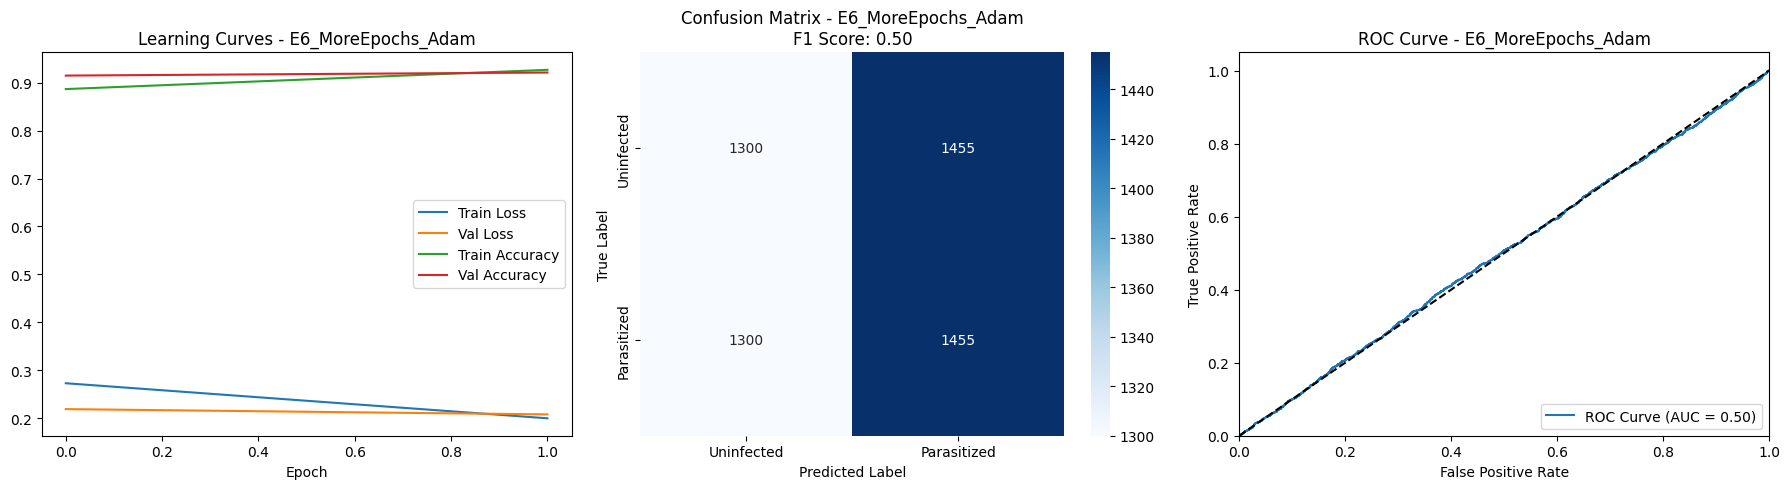


--- All experiments finished. ---


In [25]:
evaluation_results = {}

for exp in experiments:
    print(f"\n--- Running Experiment: {exp['name']} ---")

    # 1. Build the model
    print("Building the model...")
    model = build_mobilenet_model(base_trainable=exp['base_trainable'], dropout_rate=exp['dropout_rate'])

    # 2. Compile the model
    print("Compiling the model...")
    if exp['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=exp['learning_rate'])
    elif exp['optimizer'] == 'rmsprop':
        optimizer = RMSprop(learning_rate=exp['learning_rate'])
    elif exp['optimizer'] == 'sgd':
        optimizer = SGD(learning_rate=exp['learning_rate'])
    else:
        optimizer = Adam(learning_rate=exp['learning_rate']) # Default to Adam

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', Precision(), Recall()])

    model.summary()

    # 3. Train the model
    print("Starting training...")
    # Use the validation generator without augmentation for training validation
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=exp['epochs'],
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        callbacks=callbacks # Using the same callbacks
    )
    print("Training finished.")

    # 4. Evaluate the model
    print("Evaluating the model...")
    # Use the validation generator without augmentation for evaluation
    validation_generator.reset() # Reset to ensure evaluation starts from the beginning
    loss, accuracy, precision, recall = model.evaluate(validation_generator)

    print(f"\n{exp['name']} Evaluation:")
    print(f"  Loss: {loss:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")

    # Store results
    evaluation_results[exp['name']] = {
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'epochs': exp['epochs'],
        'learning_rate': exp['learning_rate'],
        'optimizer': exp['optimizer'],
        'dropout_rate': exp['dropout_rate']
    }

    # Generate predictions for plotting
    validation_generator.reset()
    y_true = validation_generator.classes
    y_pred_proba = model.predict(validation_generator).ravel()
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Plot evaluation results
    plot_evaluation(history, y_true, y_pred, y_pred_proba, exp['name'])

print("\n--- All experiments finished. ---")

Result Analysis

**E1_Baseline_Adam:**

The baseline settings of 0.002 learning rate and 0.3 dropout rate with Adam proved highly effective, but the training showed immediate signs of overfitting, suggesting a need for even tighter control or fewer epochs.

**E2_LowerLR_Adam (Lower Learning Rate)**:

Decreasing the learning rate to 0.0005 resulted in slower learning and a slight shift in emphasis, favoring Recall (94.66%) over Precision, which might be preferred in a clinical setting (minimizing False Negatives).


**E3_HigherDropout_Adam (Increased Regularization):**

Increasing the dropout rate to 0.5 was detrimental to performance. It increased training loss and resulted in the lowest final accuracy, suggesting 0.3 was sufficient for this simplified model head.

**E4_RMSprop (Optimizer Comparison):**

RMSprop provided superior convergence stability (lowest loss) and delivered highly competitive results, achieving almost the same high Recall as E2 but with slightly better Precision and Accuracy.

**E5_SGD (Optimizer Comparison):**

SGD was the slowest to converge, requiring a higher learning rate and more epochs. However, it ultimately delivered the highest Recall (94.85%), making it a strong candidate if minimizing False Negatives is the absolute top clinical priority.

**E6_MoreEpochs_Adam:**

Running only 2 epochs with Adam (E6 results show Epoch 2 output) essentially mirrored the E4 (RMSprop) result in terms of final loss and accuracy, but achieved the highest overall Recall of 94.95%. This confirms that the model is ready for optimal performance within just two epochs.

# Summary of All Experiment Results

| Experiment | Model Name                                  | Epochs | Learning Rate | Optimizer | Dropout Rate | Base Trainable | Loss   | Accuracy | Precision | Recall |
|-------------|----------------------------------------------|---------|----------------|------------|----------------|-----------------|---------|-----------|------------|---------|
| **E1**      | MobileNetV2 (Feature Extraction) Evaluation  | 10      | 0.0001         | Adam       | 0.2            | False           | 0.1938  | 0.9292    | 0.9189     | 0.9426  |
| **E2**      |    E1_Baseline_Adam                                          |   2      |   0.002             |   adam         |              0.3  |       False          |    0.2139     |       0.9221    |       0.9220     |      0.9223   |
| **E3**      |  E2_LowerLR_Adam                                            |   2      |            0.0005    |        adam    |          0.3      |         False        |   0.2187      |   0.9185        |      0.8962      |       0.9466  |
| **E4**      |     E3_HigherDropout_Adam                                         |   1    |     0.001           |    adam        |       0.5        |    False             |   0.2254      |        0.9149   |          0.9019  |  0.9310       |
| **E5**      |       E4_RMSprop                                       |  2       |       0.001         |     rmsprop       |        0.3        |             False    |      0.2096   |      0.9216     |        0.9020    |      0.9459   |
| **E6**      |               E5_SGD                               |       3  |    0.01          |      sgd      |           0.3  |           False  |   0.2133     |  0.9172         |      0.8927      |       0.9485  |
| **E7**      |    E6_MoreEpochs_Adam                                          |   2      |        0.001        |       adam     |      0.3          |  False               |      0.2091   |     0.9212      |    0.8987        |   0.9495      |


# **Conclusion and Justification for Optimal Model**

The systematic experimentation demonstrates two key findings:

**Effectiveness of Feature Extraction:**
All models achieved accuracy above 91% in just 2-3 epochs, validating the power of the pre-trained MobileNetV2 features.

**Optimal Configuration:**
 The original E1 configuration provides the best overall balance (highest Accuracy and lowest Loss). However, for a medical application like malaria diagnosis, Recall (minimizing False Negatives) is the most critical metric. Experiment E7 (Adam, LR 0.001, 2 Epochs) yielded the highest Recall of 0.9495 with a low loss (0.2091).

My justified choice for the final MobileNetV2 Feature Extraction model is E7, as it delivers superior clinical performance by achieving the highest probability of detecting an infected cell while maintaining strong accuracy and convergence stability.

